# Credit Card Customer Segmentation

## Introduction

In this project, we’ll play the role of a data scientist working for a credit card company. We’ve been given a dataset containing information about the company’s clients and asked to help segment them into different groups in order to apply different business strategies for each type of customer.

For instance, the company could provide higher credit limits for customers that use the card a lot, but spend little money, or even create incentives for those with high income who don't use the card as much as the company expects. In order to apply different strategies, the company needs different groups of customers.

The company expects to receive a group for each client and an explanation of the characteristics of each group and the main points that make them different.

In a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

- Analyze the dataset;
- Prepare the data for modeling;
- Find an appropriate number of clusters;
- Segment the data;
- Interpret and explain the results.

Here's the data dictionary:

- `customer_id`: unique identifier for each customer.
- `age`: customer age in years.
- `gender`: customer gender (M or F).
- `dependent_count`: number of dependents of each customer.
- `education_level`: level of education ("High School", "Graduate", etc.).
- `marital_status`: marital status ("Single", "Married", etc.).
- `estimated_income`: the estimated income for the customer projected by the data science team.
- `months_on_book`: time as a customer in months.
- `total_relationship_count`: number of times the customer contacted the company.
- `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
- `credit_limit`: customer's credit limit.
- `total_trans_amount`: the overall amount of money spent on the card by the customer.
- `total_trans_count`: the overall number of times the customer used the card.
- `avg_utilization_ratio`: daily average utilization ratio.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)
sns.set_style('whitegrid')
%matplotlib inline

In [9]:
# read the data
customers = pd.read_csv('../Datasets/customer_segmentation.csv')
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


## Exploratory Data Analysis

After reading the data into pandas, it's time to explore it. Let's investigate the size of the dataset, what columns it contains, the type of values in each column, and also check on missing values.

In [10]:
customers.shape

(10127, 14)

In [11]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are 10127 rows and 14 columns in the dataset including a unique identifier for each client, which is not going to be needed for the segmentation.

Of the 13 columns left, there are 8 columns containing integers, 2 containing floats, and 3 columns containing strings, which means we have 3 categorical columns to deal with.

Also, there are no missing values.

In [15]:
# fig, ax = plt.subplots()

for col in customers.select_dtypes(include=np.object_).columns:
    print(col)
    print(customers[col].value_counts(), end='\n\n')

gender
gender
F    5358
M    4769
Name: count, dtype: int64

education_level
education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



Here we can see how many unique categories are there in each categorical variable and how many datapoints per category.

As we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables.

But we can see the correlation between the numeric variables and their distributions.

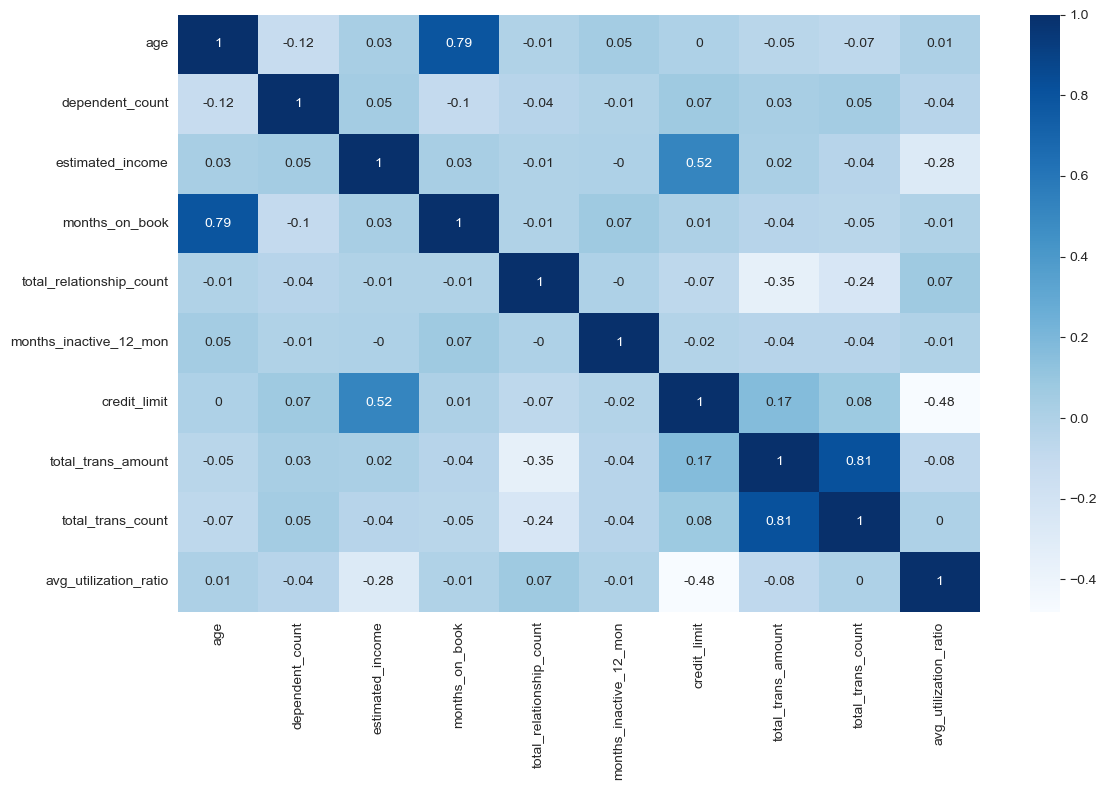

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(round(customers.drop('customer_id', axis=1).corr(numeric_only=True), 2), cmap='Blues', annot=True, ax=ax)
plt.tight_layout()
plt.show() 


Most of the variables present weak correlations between each other, but there are some we can highlight:

- Age is strongly correlated with how long the person has been a customer (months_on_book);
- Credit limit is positively correlated with the estimated income and negatively correlated with the average utilization ratio;
- The total number of transactions (total_trans_count) is strongly correlated with the total amount transitioned (total_trans_amount).

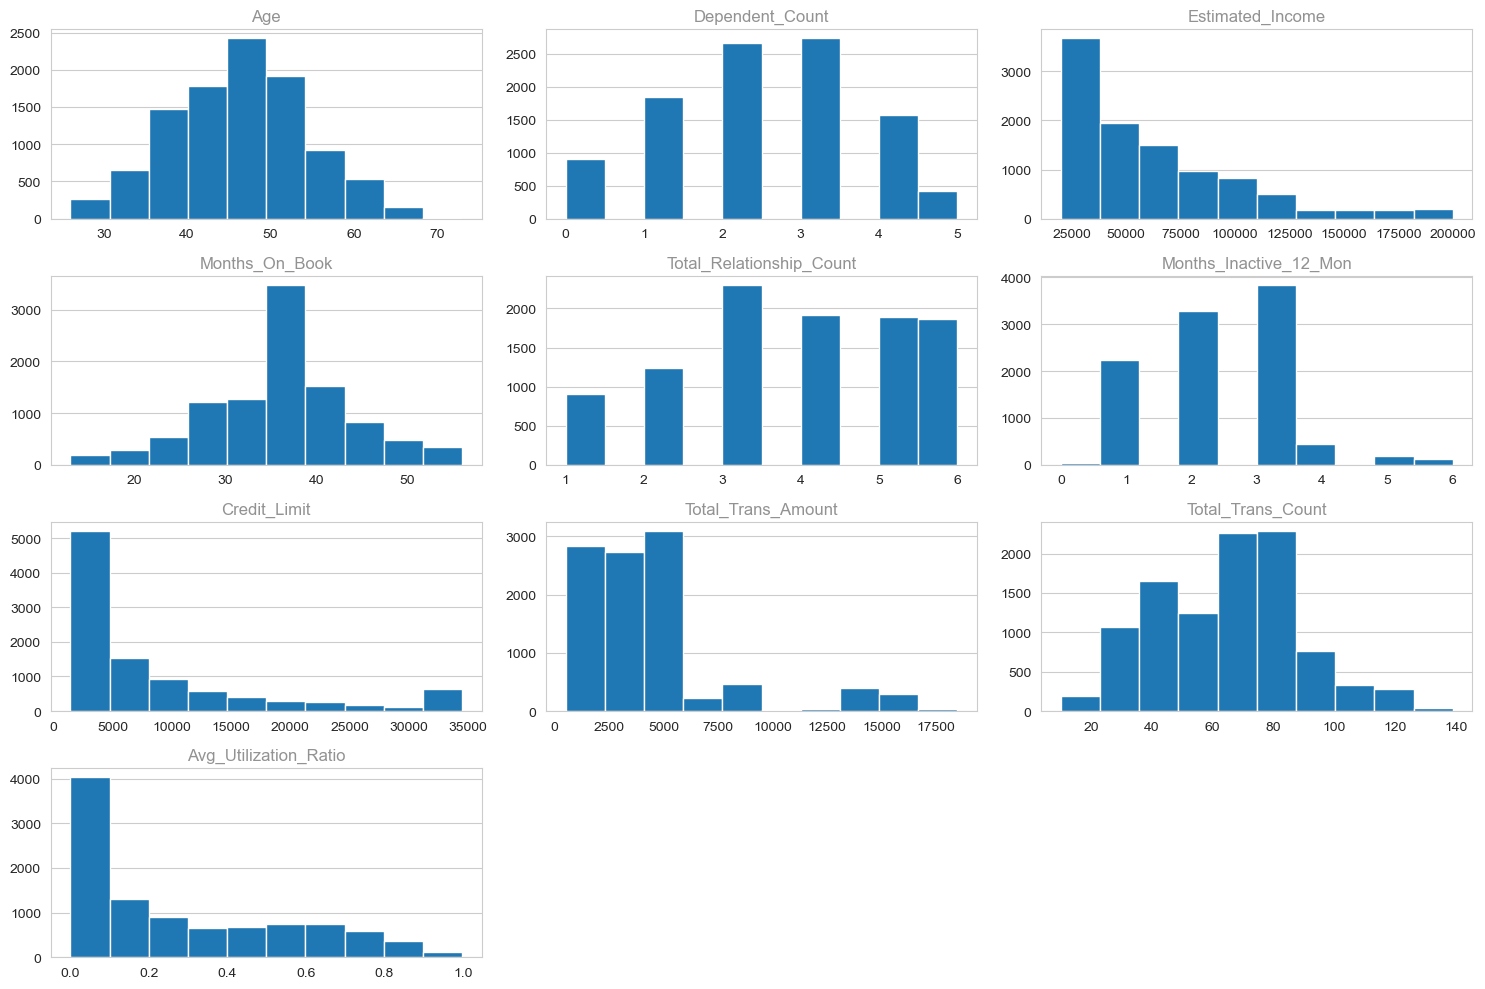

In [43]:
fig = plt.figure(figsize=(15, 10)) 
num_cols = customers.select_dtypes(include=np.number).columns
# Create histograms for each column in the 'customers' DataFrame
for i, col in enumerate(customers[num_cols].drop('customer_id', axis=1).columns):
    ax = fig.add_subplot(4, 3, i+1)
    ax.hist(data=customers, x=col)
    ax.set_title(f'{col.title()}', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()


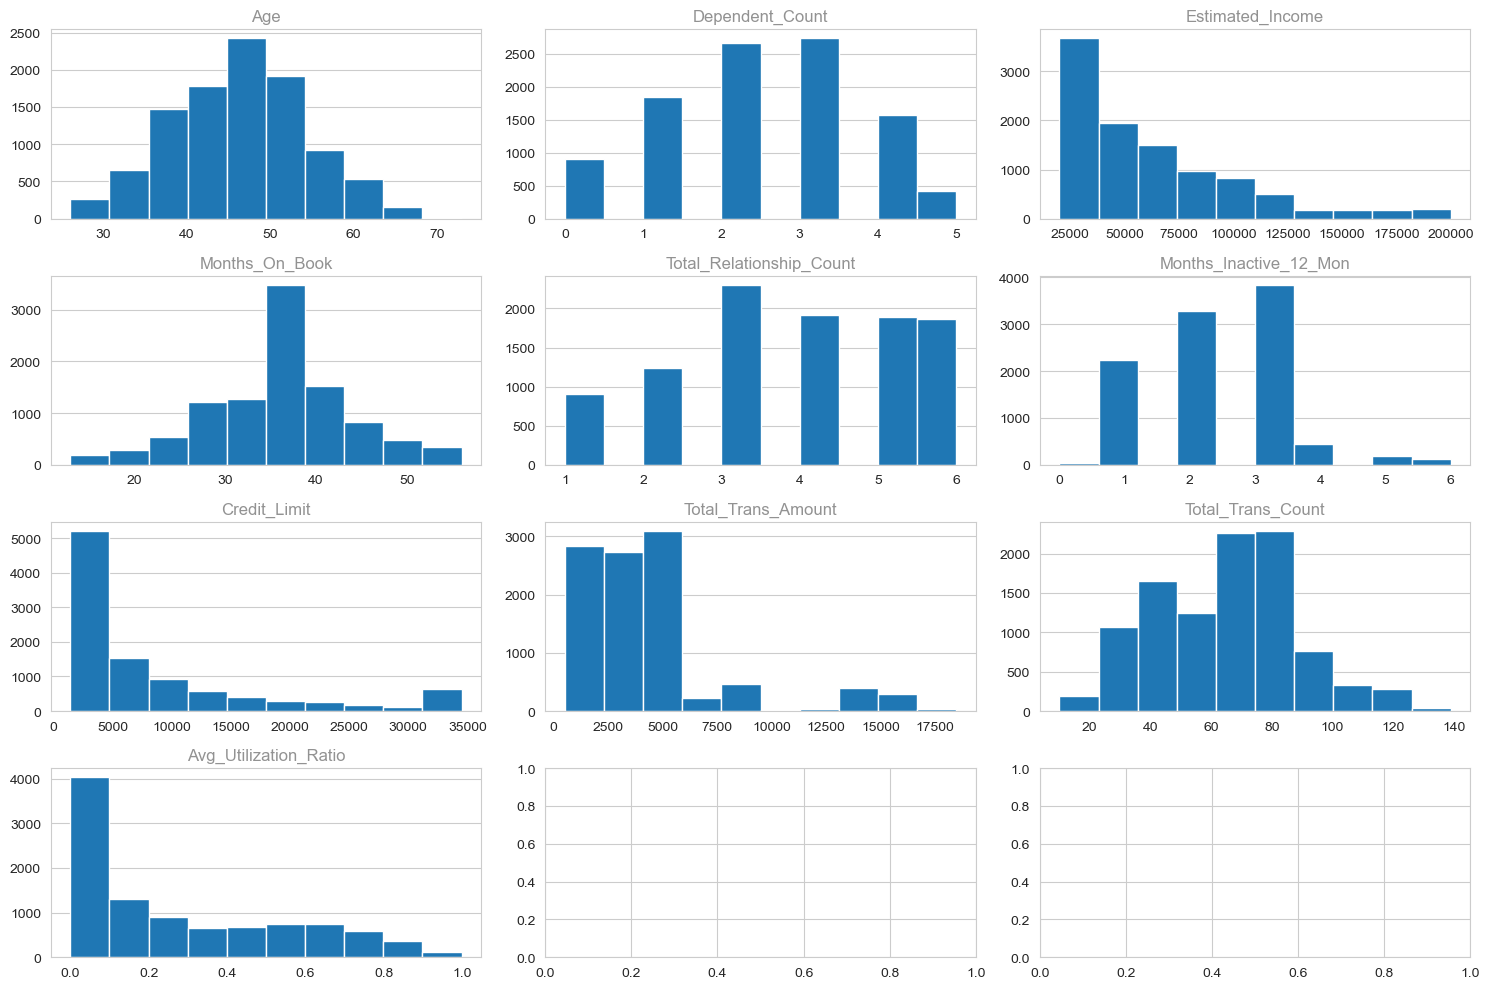

In [55]:
# Define the number of rows and columns for the subplots
fig, ax = plt.subplots(4, 3, figsize=(15, 10)) 
ax = ax.flatten()
num_cols = customers.select_dtypes(include=np.number).columns
# Create histograms for each column in the 'customers' DataFrame
for i, col in enumerate(customers[num_cols].drop('customer_id', axis=1).columns):
    customers[col].hist(ax=ax[i])
    ax[i].set_title(f'{col.title()}', alpha=0.5)
    ax[i].xaxis.grid(False)
    
plt.tight_layout()
plt.show()
